This code was ran in this configuration: 
* Jupyter Lab version -> 4.0.5 
* Python version -> 3.11.5

# Importing relevant libraries

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, stft
import pandas as pd

# part (a)

Script a function named gentone that can generate the tone associated with any key of the
keypad from 0 to 9. Run the script and provide us with an example of a tone that we can
execute and reproduce the result. Plot the signal as a function of time.

In [18]:

# input (key) should be string corespinding to the number on the keypad. It could be also '*' and '#'. 
def gentone(key = '#', T=1, dt = 1e-6):
    """ 
    gentone function that can generate the tone associated with any key of the keypad from 0 to 9 plus # and *

    Parameters
    ----------
    key : int, optional
        The key for which the tone is produced, by default is #
    T: float, optional
        The duration of signal [seconds], by default 1
    dt: float, optional
        Sampling time step [seconds], by default 1e-6
        by choosing this sampling rate we ensure we are capturing all the frequencies (the sampling rate is faster than Nyquist frequency of highest frequency)

    Returns
    ----------
    t : time array from 0 to T
    signal : signal points corresponding the time array
    """
    
    # time points
    t = np.arange(0, T, dt)
    
    # keypad keys in a (4 by 3) matrix
    keypad_keys = np.array([['1', '2', '3'], ['4', '5', '6'], ['7', '8', '9'], ['*', '0', '#']])
    
    # frequencies related to each row and column of keypad
    row_frequencies = np.array([697, 770, 852, 941])
    column_frequencies = np.array([1209, 1336, 1477])

    # row and column index for the selected key 
    ri, cj = np.where(keypad_keys == key) 

    # signal points 
    signal = 0.5 * ( np.sin(2*np.pi*row_frequencies[ri] * t) + np.sin(2*np.pi*column_frequencies[cj] * t) )
    
    return t, signal 

For visualization I chose small time length for signal : 



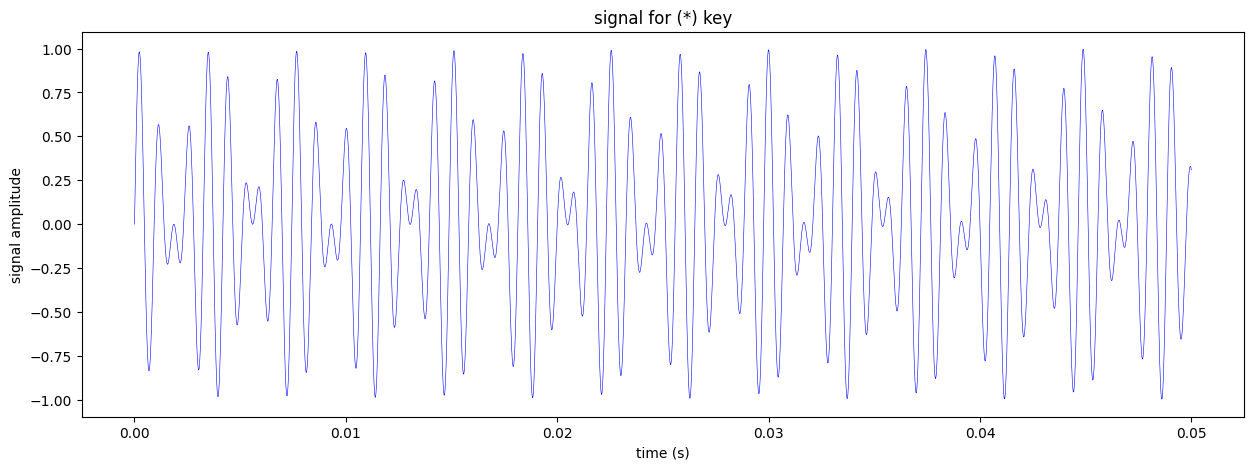

In [19]:

# select the key 
selected_key = '*'

# creation of signal with T, dt
dt, T = 1e-6, 0.05
t, signal = gentone(selected_key, T, dt)

# plotting the signal and configuring the figure
plt.figure(figsize=(15, 5))
plt.plot(t, signal, linestyle = '-', color= 'b', linewidth = 0.4)
plt.xlabel('time (s)')
plt.ylabel('signal amplitude')
plt.title('signal for (' + selected_key + ') key')
print("For visualization I chose small time length for signal : \n")
plt.show()

# part (b)


Apply Fast Fourier Transform (FFT) on the signal generated in (a) and check if you obtain
the correct frequencies. Provide the code that reads the signal and performs the FFT. Plot the
power spectrum evidencing the frequencies associated with the input signal.

In [20]:
def fft_and_peak_detector(signal, dt):
    """
    This function draw the fft transform of the input signal and returns the locations of the peaks

    Parameters
    ----------
    signal : signal we are going to do FFT on that
    dt : time steps of signal
    
    Returns
    ----------
    ax : plot of FFT Vs. frequencies between -2000 Hz and 2000 Hz
    peak_freqs : frequencies of peaks in the fft plot
    
    """
    #Turn interactive plotting off
    plt.ioff()
    
    # creating result figure
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    
    # transforming the signal using scipyft.fft method to perform the FFT
    fft_signal = fft(signal)
    # finding frequencies corresponding fft_signal using scipy.fft.fftfreq
    freqs = np.fft.fftfreq(len(signal), d=dt)
    
    # Plotting the FFT spectrum of the signal
    ax.plot(freqs, np.abs(fft_signal), linestyle = '--', color = 'g', marker = '')
     

    ######### finding the peaks of the FFT using the find_peaks method form Scipy.signal #########
    peaks = find_peaks(np.abs(fft_signal), height=1)
    peaks_loc, peaks_height = peaks[0], peaks[1]['peak_heights']

    peak_freqs = np.array(freqs[peaks_loc])

    # selecting positive and lower than 2000 Hz peaks
    index = np.logical_and(peak_freqs < 2000, peak_freqs > -2000)
    peak_freqs = peak_freqs[index]
    ##############################################################################################

    
    # bounding the frequency axis to -2000 to 2000 as we know all of our frequencies are in this band
    ax.set_xlim(-2000, 2000)

    # marking the peaks 
    ax.vlines(x=peak_freqs, ymin = 0, ymax = 1.1*np.max(peaks_height), color='r', linewidth = 0.7)
    for peak_freq in peak_freqs:
        plt.text(x= peak_freq ,y= 0.5*np.max(peaks_height) ,s=str(int(peak_freq)) + 'Hz')
    
    # plot configurations
    ax.grid(alpha=.5)
    ax.set_xlabel("freq (Hz)")
    ax.set_ylabel("frequency amplitude")
    ax.set_title("FFT of the selected key (" + str(selected_key) + ") signal")

    return ax, np.round(peak_freqs, 2)

The fft plot of tone signal and Corresponding peaks in Hz :  [  939.98  1199.98 -1199.98  -939.98]


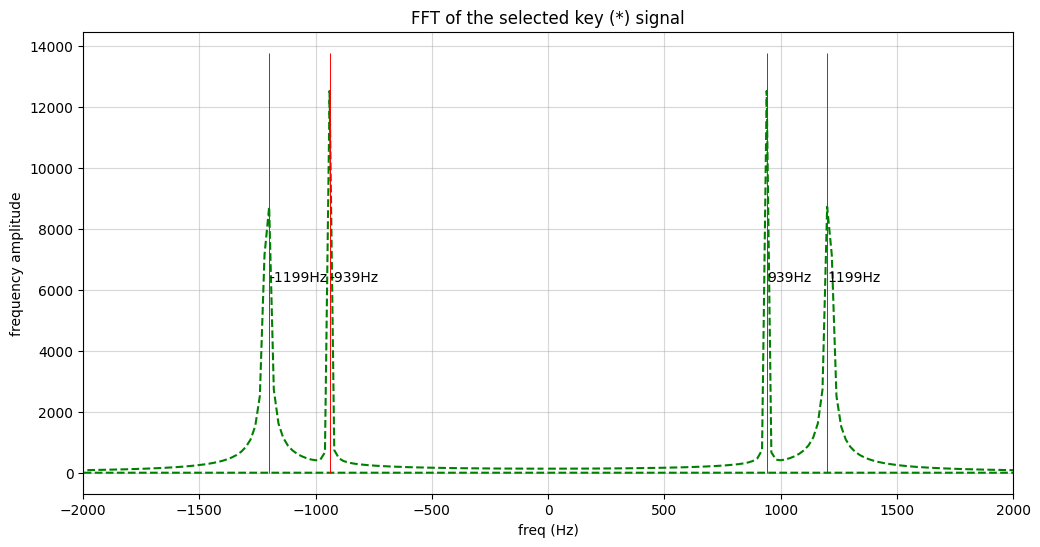

In [21]:
# creation of signal with T, dt
dt, T = 1e-6, 0.05
t, signal = gentone(selected_key, T, dt)

ax, peaks = fft_and_peak_detector(signal, dt)
print('The fft plot of tone signal and Corresponding peaks in Hz : ', peaks)
plt.show()

As we had a small length of time for the signal, the peaks are not very accurate, So we increase the time length of the tone signal to get more accurate peaks in fft

The fft plot of tone signal and Corresponding peaks :  [  941.  1209. -1209.  -941.]


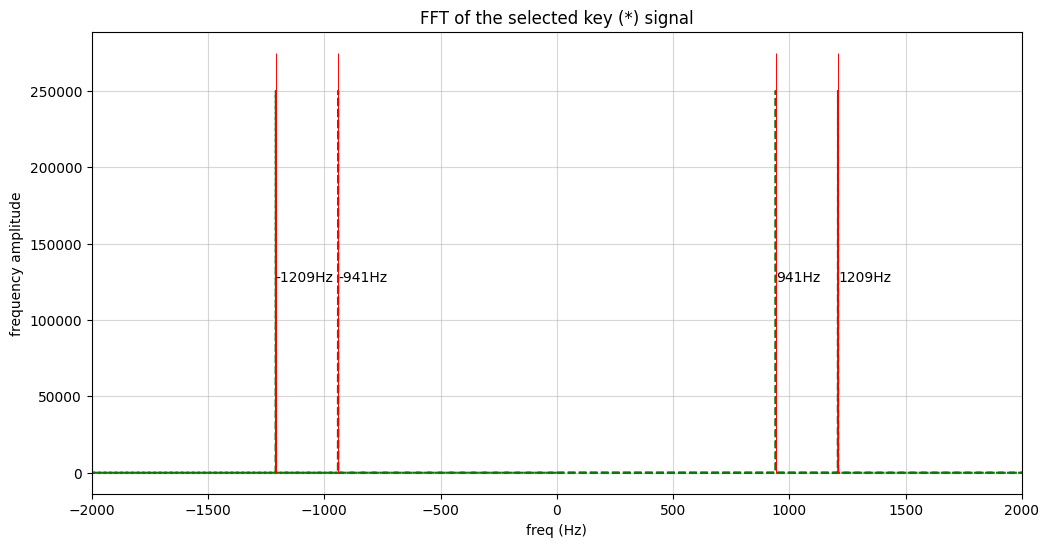

In [22]:
# creation of signal with longer duration T
dt, T = 1e-6, 1
t, signal = gentone(selected_key, T, dt)

ax, peaks = fft_and_peak_detector(signal, dt)
print('The fft plot of tone signal and Corresponding peaks : ', peaks)
plt.show()

# part (c)

Generate a 2-digit time signal in which a person presses any digit on the keypad and, after a
fraction of a second, the person presses a different digit on the keypad. Add a relatively small
random noise to the signal. Provide the script and plot the signal as a function of time.

In [23]:
def OU_noise(dt, T, gamma=10, g=0.5):
    """
    this function based on stochastical calculus gives us an Ornstein–Uhlenbeck signal which is a bounded white noise
    
    Parameters
    ----------
    gamma, g : gamma and g are two constants in the theory. 
    dt, T : time step and total time of signal
    
    Returns
    ----------
    x_array : noise signal
    
    """
    
    x = 0
    N = int(T/dt)
    x_array = np.zeros(N)

    # Due to stocastical differential calculus, for a given dt, the std of noise should be square root of itegration
    for i in range(int(3/gamma/dt)):
        x = x - gamma*x*dt + g*np.random.normal()*np.sqrt(dt)
    
    for i in range(N):
        x_array[i] = x
        x = x - gamma*x*dt + g*np.random.normal()*np.sqrt(dt)

    return x_array

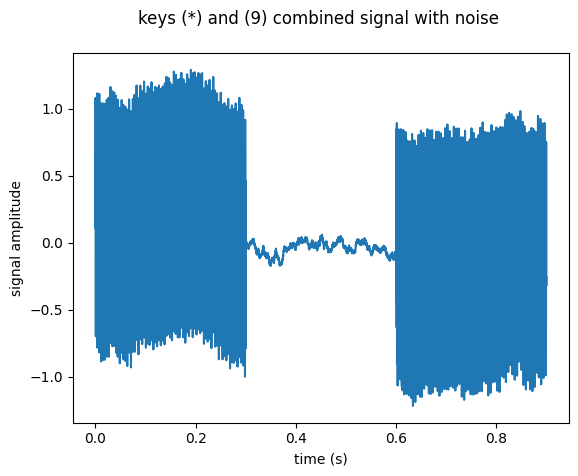

In [24]:
# Select the keys
key1 = '*'
key2 = '9'


dt = 1e-4 
T = 0.3
delay = 0.3

# creating signals seperately 
t1, signal1 = gentone(key=key1, T= T, dt=dt)
t2, signal2 = gentone(key=key2, T= T, dt=dt)

# combining signals 
combined_signal = np.concatenate((signal1, np.zeros(int(delay/dt)), signal2))
t = np.arange(len(combined_signal))*dt

# generating noise and adding to the combined signal
noise = OU_noise(dt = dt, T= len(t)*dt)
combined_signal = combined_signal + noise


# plotting the result 
plt.close()
plt.title('keys (' + key1 + ') and (' + key2 + ') combined signal with noise \n')
plt.xlabel('time (s)')
plt.ylabel('signal amplitude')
plt.plot(t, combined_signal)
plt.show()

# part (d)

Apply a short-time Fourier transform (STFT) on the signal generated in (c). Provide a time
versus frequency representation plot and check if the frequencies (and time information) correspond
to what the input signal carries.

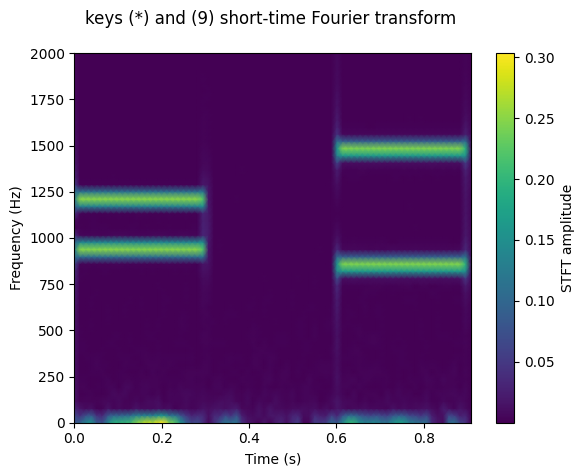

In [25]:
# stft method from scipy.signal library calculates short-time Fourier transform of a signal at each time step and gives us the amplitude of transformed signal 
# as a function of time and frequency 
freqs, time, stft_signal = stft(combined_signal, fs=int(1/dt))

# computing norm of the complex amplitudes 
stft_signal = np.abs(stft_signal)

# plotting the result and configuring the plot properties
plt.title('keys (' + key1 + ') and (' + key2 + ') short-time Fourier transform \n')
plt.pcolormesh(time,freqs, stft_signal, shading='gouraud')
plt.ylim([0, 2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='STFT amplitude') 
plt.show()

# part (e)

The file phone.dat contains the signal recorded when an 11-digit phone number is dialled. Analyze this signal and identify the phone number. Provide the code with the Fourier analysis output that reveals the phone number. The file does not contain time information but typical sampling rates in telephone audio data is 8000 Hz. Note that for this problem, the ideal sampling rate is not exactly 8000 Hz, you will need to adjust that slightly based on the knowledge of the frequencies given on the keypad and aliasing.

In [26]:
# Openening and reading the phone.dat files
file_data = None
with open('phone.dat', 'r') as file:
    file_data = file.readlines()

# reading the file and converting numbers to float
data = str(file_data[0]).split('\t')
cleaned_data = []
for index, element in enumerate(data):
    if data[index] != '\n':
        cleaned_data.append(float(data[index]))

cleaned_data = np.array(cleaned_data)

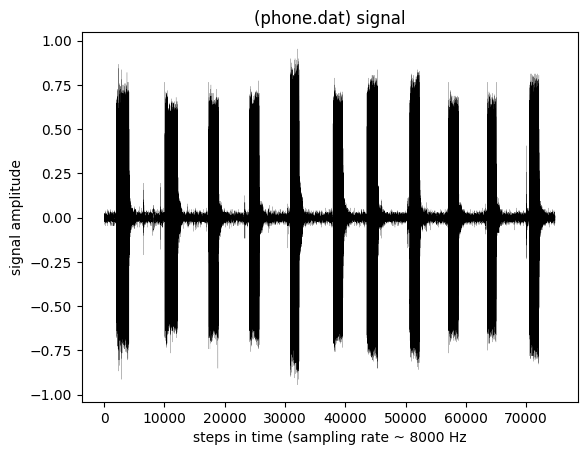

In [27]:
plt.plot(cleaned_data, 'k', linewidth = 0.1)
plt.title('(phone.dat) signal')
plt.xlabel('steps in time (sampling rate ~ 8000 Hz')
plt.ylabel('signal amplitude')
plt.show()

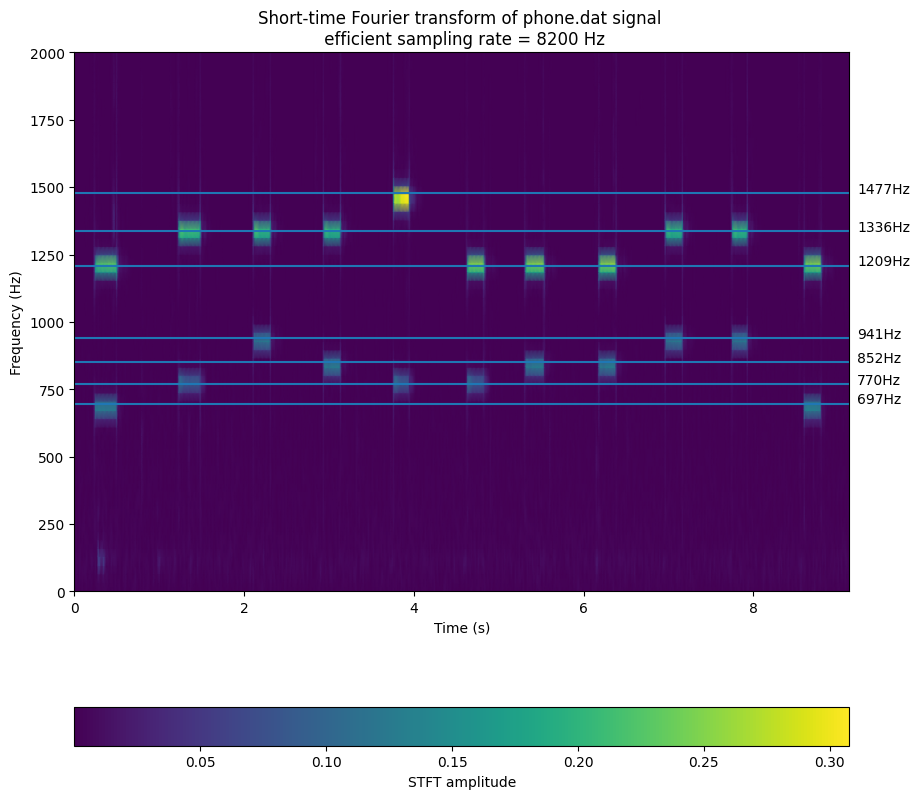

In [28]:
# in this part I repeated the procces of part (d) and plotted the horizontal lines for each frequency in keypad. Then changed the sampling rate manually to 
# adjust the pattern with lines as much as possible and started to decode the phone number from the pattern

sampling_rate = 8200

freqs, time, stft_signal = stft(cleaned_data, fs=sampling_rate)
stft_signal = np.abs(stft_signal)

fig = plt.figure(figsize=(10,10))


row_frequencies = np.array([697, 770, 852, 941])
column_frequencies = np.array([1209, 1336, 1477])


plt.pcolormesh(time, freqs, stft_signal, shading='gouraud')

plt.hlines(y = row_frequencies, xmin=0, xmax=np.max(time))

plt.hlines(y = column_frequencies, xmin=0, xmax=np.max(time))

for freq in row_frequencies:
    plt.text(x = np.max(time)*1.01, y = freq, s = str(freq) + 'Hz') 

for freq in column_frequencies:
    plt.text(x = np.max(time)*1.01, y = freq, s = str(freq) + 'Hz') 

                         

plt.ylim([0, 2000])
plt.title('Short-time Fourier transform of phone.dat signal \n efficient sampling rate = ' + str (sampling_rate) + ' Hz')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='STFT amplitude', location='bottom') 
plt.show()

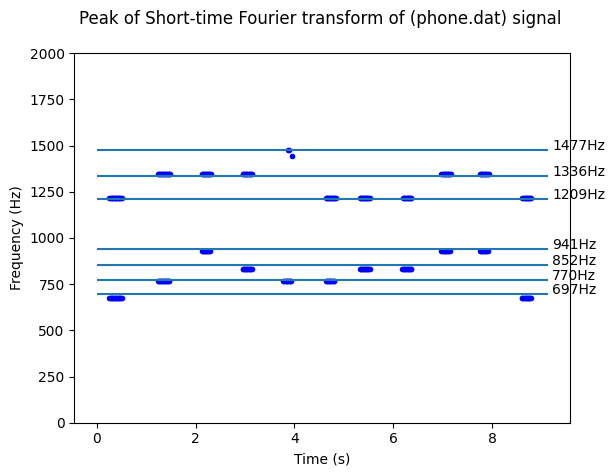

In [31]:
# in this part I found the pick of fourier signal at each time step with a threshold and plotted the peaks Vs. time and then manually compared the 
# the frequencies to the keys' frequency to decode the phone number!

peaks_save = []

for index, t in enumerate(time):
    peaks_index = find_peaks(stft_signal[:, index], threshold=0.014)[0]
    
    if len(peaks_index) != 0:
        if len(peaks_index) == 2:
            peaks_save.append(freqs[peaks_index])
        plt.plot(t*np.ones(len(peaks_index)), freqs[peaks_index], '.b')

plt.hlines(y = row_frequencies, xmin=0, xmax=np.max(time))
plt.hlines(y = column_frequencies, xmin=0, xmax=np.max(time))
for freq in row_frequencies:
    plt.text(x = np.max(time)*1.01, y = freq, s = str(freq) + 'Hz') 
for freq in column_frequencies:
    plt.text(x = np.max(time)*1.01, y = freq, s = str(freq) + 'Hz') 

plt.ylim([0, 2000])
plt.title('Peak of Short-time Fourier transform of (phone.dat) signal \n')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.show()
plt.show()

I matched the frequencies with the figure 1 of the question to find the phone number! The phone number is : 1-508-647-7001

In [34]:
peaks_save = np.array(peaks_save)

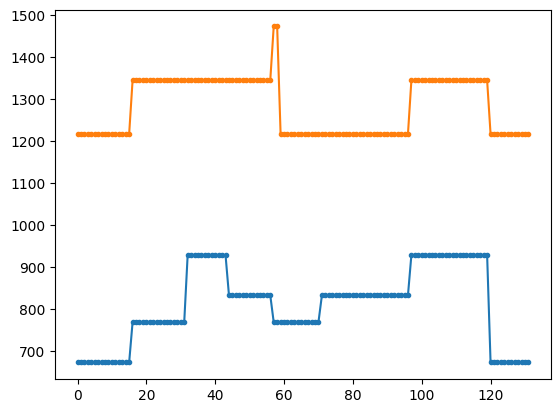

In [43]:
rows_freqs = peaks_save[:, 0]
columns_freqs = peaks_save[:, 1]

plt.plot(rows_freqs, '.-')
plt.plot(columns_freqs, '.-')
plt.show()


In [47]:
np.argsort(rows_freqs)

array([  0, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 130,  15,
        14, 131,  12,  13,  10,   9,   7,   6,   8,   4,   3,   2,   1,
         5,  11,  63,  59,  60,  61,  62,  70,  66,  67,  68,  69,  58,
        64,  57,  65,  25,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        31,  30,  26,  29,  28,  27,  86,  81,  80,  83,  82,  84,  90,
        87,  88,  89,  79,  91,  92,  93,  94,  95,  96,  85,  78,  73,
        76,  77,  53,  54,  55,  52,  51,  50,  49,  48,  56,  46,  45,
        44,  71,  72,  74,  75,  47, 111, 112, 113, 114, 118, 116, 117,
       119, 110,  43, 115, 109, 104, 107,  32,  33,  34,  41,  35,  36,
        37,  38,  39,  40,  97,  98,  99, 100, 101, 102, 103, 105, 106,
       108,  42])